# Imports

In [228]:

#SQL
import psycopg2
from credentials import HOST, DB, USR, PASS

#ETL
import pandas as pd
import numpy as np

#Gráficos
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

#Miscellania
import missingno as msno
import warnings
from collections import Counter
from tqdm import tqdm

# Separação treino-teste-validação
from sklearn.model_selection import (train_test_split, 
                                     cross_validate, 
                                     cross_val_score,
                                     StratifiedKFold)

# Balanceamento Dados
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE

#Scalers
from sklearn.preprocessing import (StandardScaler, 
                                   OrdinalEncoder, 
                                   OneHotEncoder)

#Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#Métricas
from sklearn.metrics import (accuracy_score, 
                             roc_auc_score, 
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             confusion_matrix,
                             plot_confusion_matrix,
                             plot_roc_curve,
                             classification_report,
                             SCORERS)
from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE

In [151]:
warnings.filterwarnings('ignore')

# Coleta de Dados

In [139]:
#Dados de conexão no banco

host     = HOST
db       = DB
usr      = USR
port     = '5432'
password = PASS

conn_string = f'host={host} user={usr} dbname={db} password ={password} port={port}'

In [5]:
# Estabelecer conexão com o banco
conn = psycopg2.connect(conn_string)

In [6]:
#Criação de cursor
cursor = conn.cursor()

#Query de coleta de todos dados
query = """SELECT DISTINCT f.*, o.id_pedido, o.status_pagamento, o.data_pedido,
            CASE WHEN o.status_pagamento is NULL THEN 0
                 WHEN o.status_pagamento = 'Cancelado' THEN 0
                 ELSE 1
                 END as target
            FROM forms f
            LEFT JOIN order_items oi
            ON f.id_form = oi.id_form
            LEFT JOIN orders o
            ON oi.id_pedido = o.id_pedido;"""

In [ ]:
cursor.execute(query)

In [ ]:
#Get rows
rows = cursor.fetchall()

In [ ]:
#Get Columns
cols = []
for col in cursor.description:
    cols.append(col[0])

In [ ]:
conn.close()

In [ ]:
df4u = pd.DataFrame(rows, columns = cols)

## Carregando base localmente

In [2]:
df4u = pd.read_csv('../data/dados_py.csv')

In [3]:
df4u.data = pd.to_datetime(df4u.data)

## Visualização dos dados

In [4]:
df4u.head()

,id_form,id_cliente,data,sistema_operacional,navegador,localizacao,locale,cidade,estado,qtde_lavagem_semana,...,atividade_fisica,frequencia_estresse,caracteristica,faixa_etaria,efeitos_desejados,fragancia,id_pedido,status_pagamento,data_pedido,target
0,52a843d0b7e090a05fbf29dbc8b1a4,755e5d5efaa0de273687,2022-01-01 00:13:01,Android,Chrome,"Curitiba, Parana",BR,CURITIBA,PARANA,2,...,Raramente,Uma vez por mês,Característica 1,18 a 24,"Efeito 6, Efeito 2, Efeito 4, Efeito 3, Efeito 1",Rosas,NaN,NaN,NaN,0
1,0eec183ffa8b5ea2b50bad7247ef7a,af4f02a79c7f0a318dd3,2022-01-01 00:16:14,Android,Chrome,"Curitiba, Parana",BR,CURITIBA,PARANA,4,...,Frequente,Nunca,Característica 7,11 a 17,"Efeito 6, Efeito 7, Efeito 4, Efeito 1",Flores do campo,NaN,NaN,NaN,0
2,1c35d70c95b2d2c8f6be4ff6f84b96,67d9e56f53f9fb49af6f,2022-01-01 00:17:06,Android,Chrome,"Montes Claros, Minas Gerais",BR,MONTES CLAROS,MINAS GERAIS,1,...,Raramente,Uma vez por mês,Característica 3,18 a 24,"Efeito 6, Efeito 7, Efeito 8, Efeito 1, Efeito 5",Eucalipto,NaN,NaN,NaN,0
3,593a259a51f2f00a15db33946d6d65,e0d69ea9eb3a130f5766,2022-01-01 00:17:14,iOS,NaN,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,5,...,Raramente,Uma vez por mês,Característica 2,45 a 54,"Efeito 1, Efeito 5, Efeito 7, Efeito 8",Rosas,NaN,NaN,NaN,0
4,44f20b125e4971eca764ccc4dadfcd,d687ea972ccb5373c605,2022-01-01 00:24:01,Android,Chrome,"Curitiba, Parana",BR,CURITIBA,PARANA,2,...,Raramente,Uma vez por mês,Característica 1,18 a 24,"Efeito 6, Efeito 2, Efeito 4, Efeito 3, Efeito 1",Rosas,NaN,NaN,NaN,0


In [5]:
df4u.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       'utm_source', 'tipo_cabelo', 'comprimento', 'tipo_fios',
       'procedimentos', 'tempo_procedimento', 'dieta', 'atividade_fisica',
       'frequencia_estresse', 'caracteristica', 'faixa_etaria',
       'efeitos_desejados', 'fragancia', 'id_pedido', 'status_pagamento',
       'data_pedido', 'target'],
      dtype='object')

* Assumiu-se que pedidos 'Entregue', 'Em transporte' e 'Pagamento confirmado' constituem compras bem sucedidas. Pedidos cancelados entram como lead que não concretizou compra.
* Há casos onde um único formulário foi utilizado em vários pedidos. Nesse caso, esses pedidos serão considerados como duplicatas e serão contabilizados apenas uma vez.

In [7]:
#Salvando a base
df4u.to_csv('csv/dados_py.csv', index = False)

In [6]:
df4u.shape

(431114, 27)

In [7]:
df4u.sort_values(by='data', inplace = True)

In [9]:
df4u.data = pd.to_datetime(df4u.data)

In [12]:
df4u['mes'] = df4u.data.dt.month

In [15]:
df4u.groupby('mes')['id_form'].count().mean()

71852.33333333333

Em média são realizados cerca de 72 mil formulários ao mês.

In [10]:
df4u.status_pagamento.value_counts()

Entregue                33778
Cancelado               11173
Pagamento aprovado       9352
Em transporte            2893
Aguardando pagamento      108
Criado                      1
Name: status_pagamento, dtype: int64

In [16]:
df4u = df4u[(df4u.status_pagamento != 'Cancelado') & (df4u.status_pagamento != 'Aguardando pagamento') & (df4u.status_pagamento != 'Criado')]

In [21]:
#Drop de colunas de ID e data
df = df4u.drop(['id_form','id_cliente','data','data_pedido','id_pedido', 'status_pagamento','mes'], axis = 1)

In [22]:
df.columns

Index(['sistema_operacional', 'navegador', 'localizacao', 'locale', 'cidade',
       'estado', 'qtde_lavagem_semana', 'utm_source', 'tipo_cabelo',
       'comprimento', 'tipo_fios', 'procedimentos', 'tempo_procedimento',
       'dieta', 'atividade_fisica', 'frequencia_estresse', 'caracteristica',
       'faixa_etaria', 'efeitos_desejados', 'fragancia', 'target'],
      dtype='object')

In [23]:
df.head()

,sistema_operacional,navegador,localizacao,locale,cidade,estado,qtde_lavagem_semana,utm_source,tipo_cabelo,comprimento,...,procedimentos,tempo_procedimento,dieta,atividade_fisica,frequencia_estresse,caracteristica,faixa_etaria,efeitos_desejados,fragancia,target
0,Android,Chrome,"Curitiba, Parana",BR,CURITIBA,PARANA,2,linktree,Tipo 2,Raíz exposta,...,Todos acima,Há mais de 1 mês,Celíaca,Raramente,Uma vez por mês,Característica 1,18 a 24,"Efeito 6, Efeito 2, Efeito 4, Efeito 3, Efeito 1",Rosas,0
1,Android,Chrome,"Curitiba, Parana",BR,CURITIBA,PARANA,4,influencer,Tipo 2,Muito curto,...,Todos acima,Há mais de 1 mês,Celíaca,Frequente,Nunca,Característica 7,11 a 17,"Efeito 6, Efeito 7, Efeito 4, Efeito 1",Flores do campo,0
2,Android,Chrome,"Montes Claros, Minas Gerais",BR,MONTES CLAROS,MINAS GERAIS,1,google,Tipo 2,Raíz exposta,...,Corte agressivo,Há 2 semanas,Celíaca,Raramente,Uma vez por mês,Característica 3,18 a 24,"Efeito 6, Efeito 7, Efeito 8, Efeito 1, Efeito 5",Eucalipto,0
3,iOS,NaN,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,5,facebook,Tipo 1,Muito curto,...,Todos acima,Há mais de 1 mês,Celíaca,Raramente,Uma vez por mês,Característica 2,45 a 54,"Efeito 1, Efeito 5, Efeito 7, Efeito 8",Rosas,0
4,Android,Chrome,"Curitiba, Parana",BR,CURITIBA,PARANA,2,linktree,Tipo 2,Raíz exposta,...,Todos acima,Há mais de 1 mês,Celíaca,Raramente,Uma vez por mês,Característica 1,18 a 24,"Efeito 6, Efeito 2, Efeito 4, Efeito 3, Efeito 1",Rosas,0


In [24]:
df.shape

(419832, 21)

Filtrando formularios apenas de estados com mais de 100 pedidos

In [25]:
df['count_estado'] = df.groupby('estado')['navegador'].transform('count')

In [26]:
df = df[df['count_estado'] > 100].drop('count_estado',axis = 1)

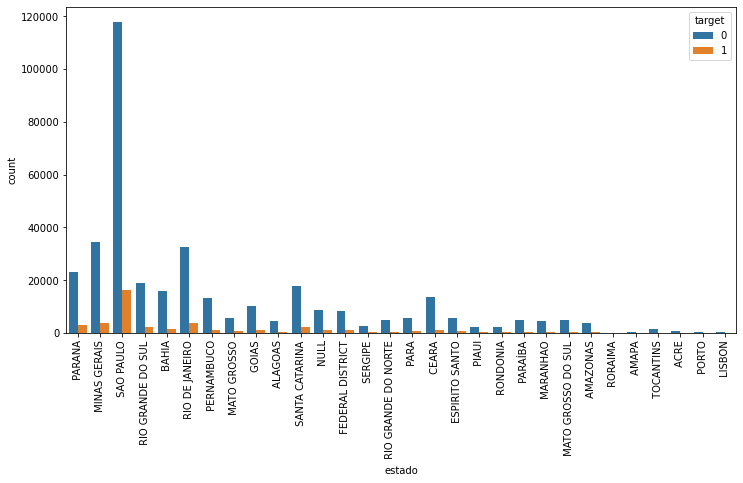

In [27]:
plt.figure(figsize =(12,6))
sns.countplot(data = df, x='estado', hue = 'target')

plt.xticks(rotation = 90)
plt.show()

# Avaliação de variáveis categóricas

In [28]:
df.select_dtypes('object').nunique().sort_values(ascending = False)

efeitos_desejados      11765
localizacao             4622
cidade                  4324
caracteristica          1928
procedimentos             66
utm_source                38
estado                    30
faixa_etaria               8
navegador                  8
sistema_operacional        6
atividade_fisica           5
tempo_procedimento         5
frequencia_estresse        4
tipo_fios                  4
dieta                      4
comprimento                4
tipo_cabelo                4
fragancia                  3
locale                     1
dtype: int64

# Formatação features

Será feita uma avaliação inicial das features para verificar se o significados das valores pode contribuir para otimizar o processo de modelagem

In [29]:
cat_m10 = (df.select_dtypes('object').nunique() < 10)[(df.select_dtypes('object').nunique() < 10)].index

In [30]:
len(cat_m10)

12

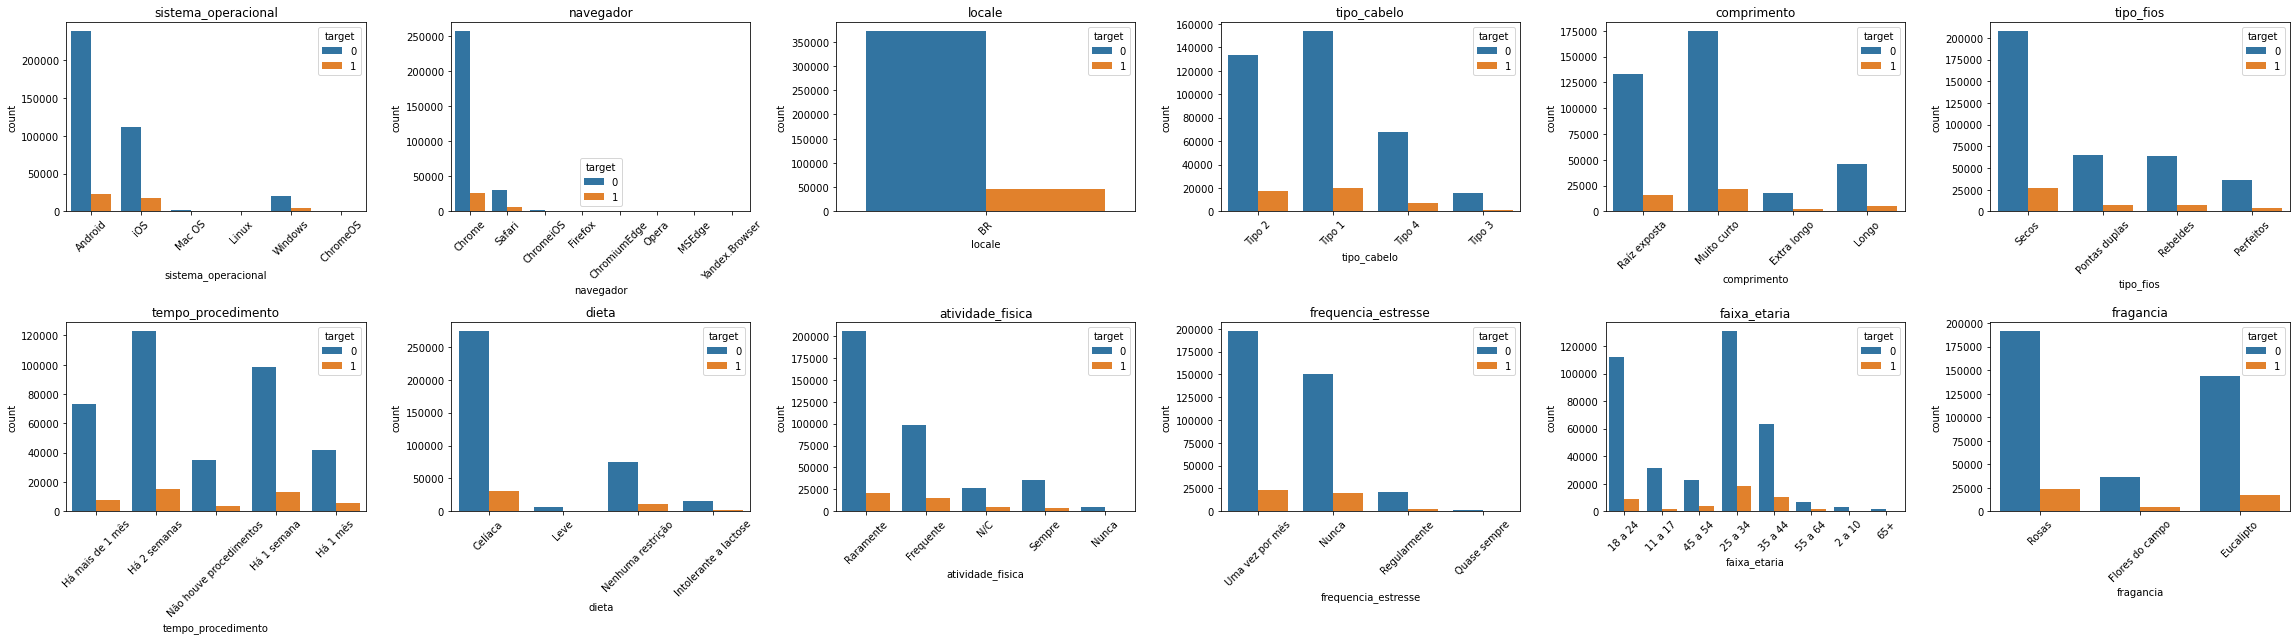

In [31]:
f, ax = plt.subplots(figsize=(32,9), nrows=2, ncols = int(len(cat_m10)/2))
c=0
l=0
for catcol in cat_m10:
    sns.countplot(x=catcol, data = df, hue = 'target', ax = ax[l][c])
    ax[l][c].tick_params(axis='x', rotation=45)
    ax[l][c].set_title(catcol)
    if c<len(cat_m10)/2-1:
        c+=1
    else:
        c=0
        l+=1
        
plt.tight_layout()

* A maior parte dos clientes acessa a plataforma por celular via Android ou iOS, utilizando como navegador, principalmente Chrome e Safari.
* A distribuição da target é semelhantes entre as categorias das features plotadas
* A fragancia mais pedida é a de rosas seguida pela de eucalipto
* Os leads gerados estão concentrados na faixa etária de 18 a 34 anos.
* A maior parte dos formulários é preenchdia por clientes que pratica pouca atividade física
* A maior parte da base clientes é celíaco.
* O comprimento dos cabelos descritos é, em sua maioria, de raíz exposta ou muito curto e de fios secos.

In [32]:
# FEATURE LOCALE
df.locale.value_counts()

BR    417142
Name: locale, dtype: int64

In [33]:
#Coluna sem variabilidade será dropada
df.drop('locale', axis = 1, inplace = True)

In [34]:
# FEATURE LOCALIZACAO
df.localizacao.value_counts()

São Paulo, Sao Paulo              51624
Rio de Janeiro, Rio de Janeiro    19051
Belo Horizonte, Minas Gerais      10583
null, null                         9821
Brasília, Federal District         9319
                                  ...  
Cachoeira do Arari, Para              1
Julio Borges, Piaui                   1
Montividiu do Norte, Goias            1
Rio Tinto, Paraíba                    1
Tejupa, Sao Paulo                     1
Name: localizacao, Length: 4622, dtype: int64

In [35]:
# Mesma info de cidade e estado, portanto será dropada.
df.drop('localizacao', axis =1, inplace = True)

efeitos_desejados     OK 
cidade                OK               
caracteristica        OK 
estado                OK              
procedimentos         OK    
utm_source            OK

In [36]:
#Feature utm_source
df.utm_source.value_counts().sort_index()

Facebook ads            1
IGShopping           2960
adwords               723
all                     1
blog                 1302
copy_link               1
cpc                     4
email                   1
email_sf             1631
facebook            98107
facebook                3
google              35654
incicacao              65
influencer         126876
instagram           20438
linktree            23339
meliuz                 60
microinfluencer       766
popup                   2
rakuten              3068
salesforce             42
santander               1
sendinblue             19
sf_                     1
sf_camp_email           2
sf_email_camp       13997
sf_email_flux         327
sf_sms_camp            10
sf_wpp_camp         23956
sf_wpp_flu              4
sf_wpp_flux          8559
site                  605
sms                     4
telegram               17
teste_source            1
tiktok                963
uaubox                  2
whatsapp               24
Name: utm_so

* Canal por onde o cliente chegou até a empresa
* sf_wpp_flu e sf_wpp_flux devem ser o mesmo tipo
* facebook duplicado
* Vários grupos são semelhantes mas estão segmentados como email, whatsapp, facebook, salesforce

In [37]:
#Feature Procedimentos
df.procedimentos.value_counts() 

Corte agressivo                                       77776
Todos acima                                           67556
Tintura                                               37480
Exposição ao sol                                      33605
Tintura, Corte agressivo                              32510
                                                      ...  
Corte agressivo, Exposição ao sol, Tintura, Nenhum      135
Exposição ao sol, Tintura, Nenhum                       120
Exposição ao sol, Corte agressivo, Nenhum, Tintura      116
Exposição ao sol, Tintura, Nenhum, Corte agressivo       87
N/C                                                       3
Name: procedimentos, Length: 66, dtype: int64

* Tipo de ação procedimento pelo qual o cabelo passou
* Agrupamento de valores em checklist

In [38]:
df.caracteristica.value_counts()

Característica 3                                                                             113522
Característica 7                                                                              45441
Característica 1                                                                              39830
Característica 3, Característica 8                                                            35497
Característica 8                                                                              17655
                                                                                              ...  
Característica 1, Característica 6, Característica 3, Característica 8, Característica 10         1
Característica 1, Característica 3, Característica 10, Característica 9, Característica 2         1
Característica 3, Característica 4, Característica 10, Característica 8, Característica 1         1
Característica 3, Característica 4, Característica 6, Característica 10                           1


* Características pré-determinadas do cabelo 
* Agrupamento de valores em checklist

In [39]:
df.efeitos_desejados.value_counts()

Efeito 6, Efeito 7, Efeito 4, Efeito 3               6017
Efeito 6, Efeito 7, Efeito 8, Efeito 4, Efeito 3     5801
Efeito 6, Efeito 7, Efeito 8, Efeito 4               5162
Efeito 7                                             4617
Efeito 6, Efeito 2, Efeito 4, Efeito 3               3917
                                                     ... 
Efeito 10, Efeito 3, Efeito 4, Efeito 2, Efeito 1       1
Efeito 10, Efeito 2, Efeito 3, Efeito 4, Efeito 7       1
Efeito 3, Efeito 5, Efeito 2, Efeito 8, Efeito 1        1
Efeito 4, Efeito 1, Efeito 7, Efeito 2, Efeito 10       1
Efeito 8, Efeito 10, Efeito 6, Efeito 1, Efeito 7       1
Name: efeitos_desejados, Length: 11765, dtype: int64

* Efeitos a serem aplicados no cabelo pelo produto
* Agrupamento de valores em checklist

# Avaliação de variáveis Numéricas

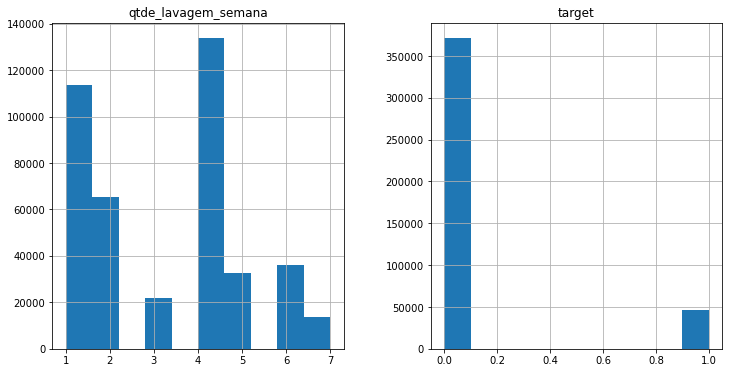

In [40]:
df.hist(figsize = (12,6))
plt.show()

## Avaliação Target

In [41]:
df.target.value_counts()

0    371326
1     45816
Name: target, dtype: int64

In [42]:
df.target.value_counts(normalize = True)

0    0.890167
1    0.109833
Name: target, dtype: float64

In [43]:
# Conversão para binário
df.target = df.target.astype('category')

# Valores Missing

In [156]:
df.isna().sum()

sistema_operacional        0
navegador              89343
estado                     0
qtde_lavagem_semana        0
utm_source             52806
tipo_cabelo                0
comprimento                0
tipo_fios                  0
tempo_procedimento         0
dieta                      0
atividade_fisica           0
frequencia_estresse        0
faixa_etaria               0
fragancia                  0
target                     0
n_efeitos                  0
efeito1                    0
efeito2                    0
efeito3                    0
efeito4                    0
efeito5                    0
efeito6                    0
efeito7                    0
efeito8                    0
efeito9                    0
efeito10                   0
n_caracteristicas          0
caracteristica1            0
caracteristica2            0
caracteristica3            0
caracteristica4            0
caracteristica5            0
caracteristica6            0
caracteristica7            0
caracteristica

In [45]:
df.dropna(axis=0, subset='estado', inplace = True)

<AxesSubplot:>

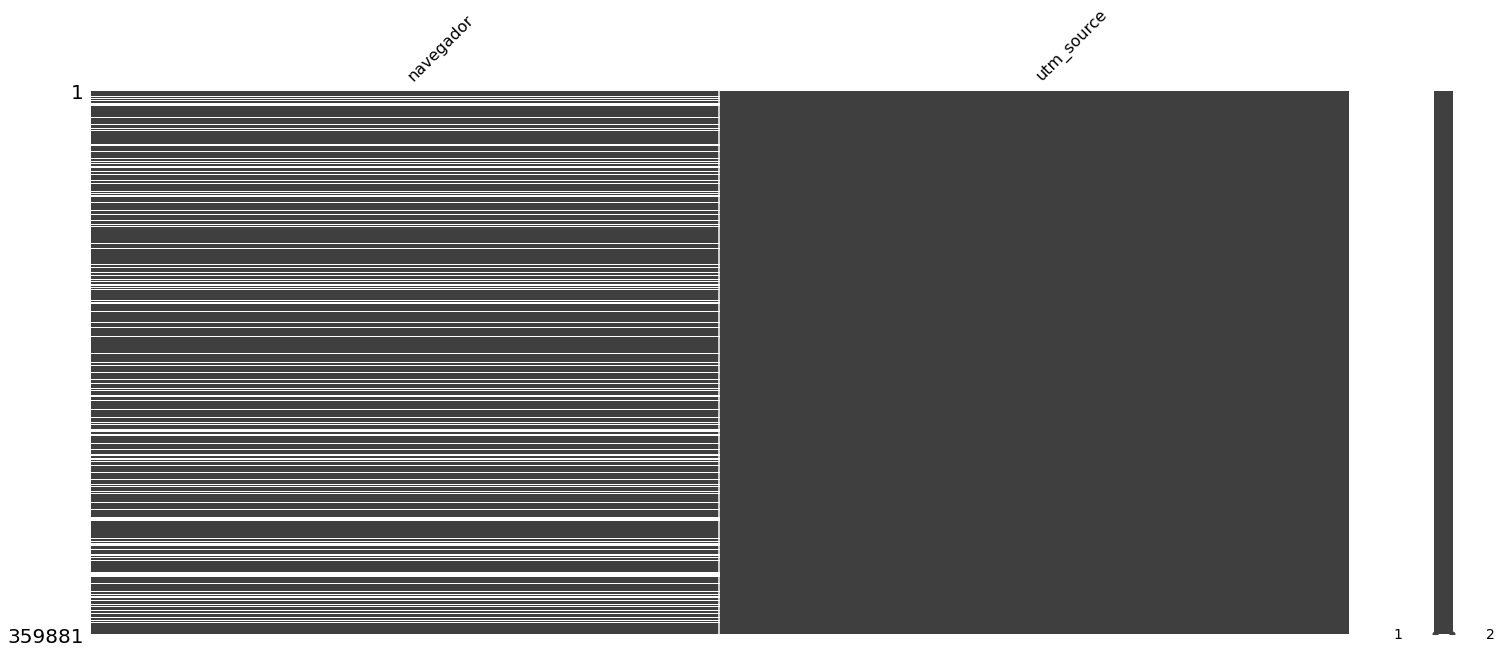

In [161]:
msno.matrix(df[['navegador','cidade','estado','utm_source','efeitos_desejados']])

* Na coluna navegador, como são muitos valores, pode ser mais conveniente retirar a coluna inteira
* No caso de cidade e estado, há chance de não serem features relevantes para o modelo
* Efeitos desejados nulos podem ser substituídos por 0
* Status do pagamento faltante apenas que o pedido nao foi realizado apesar do preenchimento do formulário, não será utilizado.

In [47]:
df.dropna(axis = 0, subset='efeitos_desejados', inplace = True)

# Valores Duplicados

In [48]:
df4u.duplicated().sum()

0

In [49]:
df.duplicated().sum()

3502

In [50]:
df.drop_duplicates(inplace = True)

# Feature Engineering (1)

## Efeitos desejados

In [51]:
df.efeitos_desejados.value_counts()

Efeito 6, Efeito 7, Efeito 4, Efeito 3               5915
Efeito 6, Efeito 7, Efeito 8, Efeito 4, Efeito 3     5645
Efeito 6, Efeito 7, Efeito 8, Efeito 4               5075
Efeito 7                                             4549
Efeito 6, Efeito 2, Efeito 4, Efeito 3               3863
                                                     ... 
Efeito 5, Efeito 3, Efeito 7, Efeito 8, Efeito 6        1
Efeito 1, Efeito 4, Efeito 7, Efeito 10, Efeito 3       1
Efeito 2, Efeito 1, Efeito 5, Efeito 10, Efeito 3       1
Efeito 10, Efeito 4, Efeito 2, Efeito 3                 1
Efeito 8, Efeito 10, Efeito 6, Efeito 1, Efeito 7       1
Name: efeitos_desejados, Length: 11765, dtype: int64

In [52]:
# Separação de efeitos por cliente em lista
df.efeitos_desejados = df.efeitos_desejados.apply(lambda x: sorted(x.split(',')) if x != 0 else 0)

In [53]:
df['n_efeitos'] = df.efeitos_desejados.apply(lambda x: len(x) if type(x) == list else 0)

In [54]:
df.efeitos_desejados

0         [ Efeito 1,  Efeito 2,  Efeito 3,  Efeito 4, E...
1               [ Efeito 1,  Efeito 4,  Efeito 7, Efeito 6]
2         [ Efeito 1,  Efeito 5,  Efeito 7,  Efeito 8, E...
3               [ Efeito 5,  Efeito 7,  Efeito 8, Efeito 1]
5              [ Efeito 2,  Efeito 4,  Efeito 5, Efeito 10]
                                ...                        
431109                                           [Efeito 6]
431110          [ Efeito 1,  Efeito 7,  Efeito 8, Efeito 6]
431111    [ Efeito 1,  Efeito 2,  Efeito 3,  Efeito 7, E...
431112                     [ Efeito 4,  Efeito 8, Efeito 7]
431113    [ Efeito 10,  Efeito 2,  Efeito 3,  Efeito 4, ...
Name: efeitos_desejados, Length: 412694, dtype: object

In [55]:
# Função para coletar todas as possibilidades de resultado dentro da coluna
def listar_unicos(efeitos, lista_unique):
    if efeitos == 0:
        return
    for efeito in efeitos:
        n_efeito = efeito.split(' ')[-1]
        lista_unique.add(n_efeito)
            

In [56]:
todos_efeitos = set()
df.efeitos_desejados.apply(listar_unicos, args = [todos_efeitos])

0         None
1         None
2         None
3         None
5         None
          ... 
431109    None
431110    None
431111    None
431112    None
431113    None
Name: efeitos_desejados, Length: 412694, dtype: object

In [57]:
#Todos os efeitos possíveis
todos_efeitos

{'1', '10', '2', '3', '4', '5', '6', '7', '8', 'N/C'}

Apesar da lista nao conter o efeito 9, pode ser devido a uma deficiencia no dataset mas que a característica seja válida. Portanto, será incluída entre as features dos dados.

In [58]:
df.efeitos_desejados

0         [ Efeito 1,  Efeito 2,  Efeito 3,  Efeito 4, E...
1               [ Efeito 1,  Efeito 4,  Efeito 7, Efeito 6]
2         [ Efeito 1,  Efeito 5,  Efeito 7,  Efeito 8, E...
3               [ Efeito 5,  Efeito 7,  Efeito 8, Efeito 1]
5              [ Efeito 2,  Efeito 4,  Efeito 5, Efeito 10]
                                ...                        
431109                                           [Efeito 6]
431110          [ Efeito 1,  Efeito 7,  Efeito 8, Efeito 6]
431111    [ Efeito 1,  Efeito 2,  Efeito 3,  Efeito 7, E...
431112                     [ Efeito 4,  Efeito 8, Efeito 7]
431113    [ Efeito 10,  Efeito 2,  Efeito 3,  Efeito 4, ...
Name: efeitos_desejados, Length: 412694, dtype: object

In [59]:
def col_efeito(efeitos, label):
    if efeitos == 0:
        return 0
    elif label in efeitos:
        return 1
    else:
        return 0

In [60]:
df['efeito1']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 1'])
df['efeito2']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 2'])
df['efeito3']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 3'])
df['efeito4']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 4'])
df['efeito5']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 5'])
df['efeito6']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 6'])
df['efeito7']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 7']) 
df['efeito8']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 8'])
df['efeito9']  = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 9'])
df['efeito10'] = df.efeitos_desejados.apply(col_efeito, args = ['Efeito 10'])

In [61]:
df.efeito1.value_counts()

0    396112
1     16582
Name: efeito1, dtype: int64

## Características

In [62]:
df.caracteristica.value_counts()

Característica 3                                                                                               112353
Característica 7                                                                                                44791
Característica 1                                                                                                39306
Característica 3, Característica 8                                                                              35228
Característica 8                                                                                                17471
                                                                                                                ...  
Característica 10, Característica 4, Característica 9, Característica 1, Característica 8                           1
Característica 8, Característica 4, Característica 6                                                                1
Característica 9, Característica 4, Característica 3, Ca

In [63]:
# Separação de caracteristica por cliente em lista
df.caracteristica = df.caracteristica.apply(lambda x: x.split(',') if x != 0 else 0)

In [64]:
df['n_caracteristicas'] = df.caracteristica.apply(lambda x: len(x) if type(x) == list else 0)

In [65]:
df.caracteristica

0                            [Característica 1]
1                            [Característica 7]
2                            [Característica 3]
3                            [Característica 2]
5                            [Característica 7]
                          ...                  
431109                       [Característica 2]
431110    [Característica 3,  Característica 8]
431111                       [Característica 3]
431112                       [Característica 1]
431113                       [Característica 3]
Name: caracteristica, Length: 412694, dtype: object

In [66]:
todas_caracteristicas= set()
df.caracteristica.apply(listar_unicos, args = [todas_caracteristicas])

0         None
1         None
2         None
3         None
5         None
          ... 
431109    None
431110    None
431111    None
431112    None
431113    None
Name: caracteristica, Length: 412694, dtype: object

In [67]:
todas_caracteristicas

{'1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'N/C'}

In [68]:
df['caracteristica1']  = df.caracteristica.apply(col_efeito, args = ['Característica 1'])
df['caracteristica2']  = df.caracteristica.apply(col_efeito, args = ['Característica 2'])
df['caracteristica3']  = df.caracteristica.apply(col_efeito, args = ['Característica 3'])
df['caracteristica4']  = df.caracteristica.apply(col_efeito, args = ['Característica 4'])
df['caracteristica5']  = df.caracteristica.apply(col_efeito, args = ['Característica 5'])
df['caracteristica6']  = df.caracteristica.apply(col_efeito, args = ['Característica 6'])
df['caracteristica7']  = df.caracteristica.apply(col_efeito, args = ['Característica 7'])
df['caracteristica8']  = df.caracteristica.apply(col_efeito, args = ['Característica 8'])
df['caracteristica9']  = df.caracteristica.apply(col_efeito, args = ['Característica 9'])
df['caracteristica10'] = df.caracteristica.apply(col_efeito, args = ['Característica 10'])

## Procedimentos

In [69]:
df.procedimentos.value_counts() 

Corte agressivo                                       76750
Todos acima                                           66663
Tintura                                               36931
Exposição ao sol                                      33123
Tintura, Corte agressivo                              32177
                                                      ...  
Corte agressivo, Exposição ao sol, Tintura, Nenhum      135
Exposição ao sol, Tintura, Nenhum                       120
Exposição ao sol, Corte agressivo, Nenhum, Tintura      116
Exposição ao sol, Tintura, Nenhum, Corte agressivo       87
N/C                                                       3
Name: procedimentos, Length: 66, dtype: int64

In [70]:
df.procedimentos = df.procedimentos.apply(lambda x: x.split(',') if x != 0 else 0)

In [71]:
df.procedimentos

0              [Todos acima]
1              [Todos acima]
2          [Corte agressivo]
3              [Todos acima]
5         [Exposição ao sol]
                 ...        
431109    [Exposição ao sol]
431110         [Todos acima]
431111     [Corte agressivo]
431112     [Corte agressivo]
431113              [Nenhum]
Name: procedimentos, Length: 412694, dtype: object

In [72]:
def listar_unicos_2(proceds, lista_unique):
    for proced in proceds:
        lista_unique.add(proced.strip())

In [73]:
todos_proceds = set()
df.procedimentos.apply(listar_unicos_2, args = [todos_proceds])

0         None
1         None
2         None
3         None
5         None
          ... 
431109    None
431110    None
431111    None
431112    None
431113    None
Name: procedimentos, Length: 412694, dtype: object

In [74]:
todos_proceds

{'Corte agressivo',
 'Exposição ao sol',
 'N/C',
 'Nenhum',
 'Tintura',
 'Todos acima'}

In [75]:
df['corteagr']  = df.procedimentos.apply(lambda x: 1 if (('Corte agressivo' in x ) | ('Todos acima' in x)) else 0)
df['tintura']   = df.procedimentos.apply(lambda x: 1 if (('Tintura' in x) | ('Todos acima' in x)) else 0)
df['exposol']   = df.procedimentos.apply(lambda x: 1 if (('Exposição ao sol' in x) | ('Todos acima' in x)) else 0)

In [76]:
df['n_procedimentos'] = df.corteagr + df.tintura+df.exposol

## UTM Source

In [77]:
df.utm_source.value_counts()

influencer         125661
facebook            97488
google              35201
sf_wpp_camp         23684
linktree            23014
instagram           20172
sf_email_camp       13845
sf_wpp_flux          8360
rakuten              3021
IGShopping           2924
email_sf             1622
blog                 1294
tiktok                943
microinfluencer       757
adwords               721
site                  603
sf_email_flux         323
incicacao              65
meliuz                 53
salesforce             42
whatsapp               24
telegram               17
sendinblue             16
sf_sms_camp            10
cpc                     4
sf_wpp_flu              4
sms                     4
facebook                3
uaubox                  2
popup                   2
sf_camp_email           2
copy_link               1
email                   1
Facebook ads            1
santander               1
all                     1
teste_source            1
sf_                     1
Name: utm_so

### Agrupando categorias 

In [78]:
df.loc[df.utm_source=='sf_wpp_flu','utm_source'] = 'sf_wpp_flux'

In [79]:
df.utm_source = df.utm_source.str.strip()

In [80]:
df.utm_source.value_counts().sort_values(ascending=False)

influencer         125661
facebook            97491
google              35201
sf_wpp_camp         23684
linktree            23014
instagram           20172
sf_email_camp       13845
sf_wpp_flux          8364
rakuten              3021
IGShopping           2924
email_sf             1622
blog                 1294
tiktok                943
microinfluencer       757
adwords               721
site                  603
sf_email_flux         323
incicacao              65
meliuz                 53
salesforce             42
whatsapp               24
telegram               17
sendinblue             16
sf_sms_camp            10
cpc                     4
sms                     4
sf_camp_email           2
popup                   2
uaubox                  2
email                   1
copy_link               1
Facebook ads            1
santander               1
all                     1
teste_source            1
sf_                     1
Name: utm_source, dtype: int64

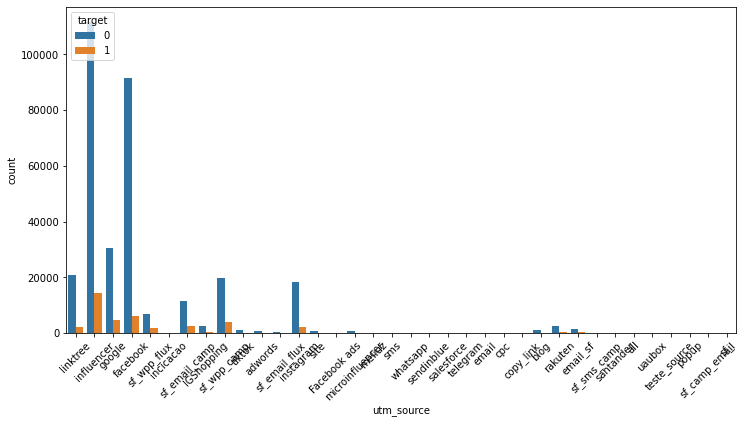

In [81]:
plt.figure(figsize=(12,6))
sns.countplot(data = df, x='utm_source', hue = 'target')
plt.xticks(rotation = 45)
plt.show()

#### Instagram

In [82]:
df.loc[df.utm_source == 'instagram', 'target'].value_counts(normalize = True)

0    0.901051
1    0.098949
Name: target, dtype: float64

In [83]:
df.loc[df.utm_source == 'IGShopping', 'target'].value_counts(normalize = True)

0    0.838919
1    0.161081
Name: target, dtype: float64

In [84]:
df.loc[df.utm_source == 'IGShopping', 'utm_source'] = 'instagram'

#### Site

In [85]:
df.loc[df.utm_source == 'popup', 'utm_source'] = 'site'

In [86]:
df.loc[df.utm_source == 'blog', 'utm_source'] = 'site'

#### 3rd Parties

In [87]:
df.loc[df.utm_source == 'meliuz', 'target'].value_counts(normalize = True)

0    0.754717
1    0.245283
Name: target, dtype: float64

In [88]:
df.loc[df.utm_source == 'salesforce', 'target'].value_counts(normalize = True)

0    0.785714
1    0.214286
Name: target, dtype: float64

In [89]:
df.loc[df.utm_source == 'sf_', 'target'].value_counts(normalize = True)

0    1.0
1    0.0
Name: target, dtype: float64

In [90]:
df.loc[df.utm_source == 'sf_sms_camp', 'target'].value_counts(normalize = True)

0    1.0
1    0.0
Name: target, dtype: float64

In [91]:
df.loc[df.utm_source == 'sendinblue', 'target'].value_counts(normalize = True)

0    0.9375
1    0.0625
Name: target, dtype: float64

In [92]:
df.loc[df.utm_source == 'sf_', 'utm_source'] = '3rd_parties'
df.loc[df.utm_source == 'meliuz', 'utm_source'] = '3rd_parties'
df.loc[df.utm_source == 'salesforce', 'utm_source'] = '3rd_parties'
df.loc[df.utm_source == 'sf_sms_camp', 'utm_source'] = '3rd_parties'
df.loc[df.utm_source == 'sendinblue', 'utm_source'] = '3rd_parties'
df.loc[df.utm_source == 'uaubox', 'utm_source'] = '3rd_parties'
df.loc[df.utm_source == 'santander', 'utm_source'] = '3rd_parties'
df.loc[df.utm_source == 'cpc', 'utm_source'] = '3rd_parties'
df.loc[df.utm_source == 'incicacao', 'utm_source'] = '3rd_parties'


#### Facebook

In [93]:
df.loc[df.utm_source == 'Facebook ads', 'utm_source'] = 'facebook'

#### Email

In [94]:
df.loc[df.utm_source == 'sf_email_camp', 'target'].value_counts(normalize = True)

0    0.828097
1    0.171903
Name: target, dtype: float64

In [95]:
df.loc[df.utm_source == 'sf_email_camp', 'utm_source'] = 'email'

In [96]:
df.loc[df.utm_source == 'sf_camp_email', 'utm_source'] = 'email'

In [97]:
df.loc[df.utm_source == 'email_sf', 'target'].value_counts(normalize = True)

0    0.885327
1    0.114673
Name: target, dtype: float64

In [98]:
df.loc[df.utm_source == 'email_sf', 'utm_source'] = 'email'

In [99]:
df.loc[df.utm_source == 'sf_email_flux', 'target'].value_counts(normalize = True)

0    0.804954
1    0.195046
Name: target, dtype: float64

In [100]:
df.loc[df.utm_source == 'sf_email_flux', 'utm_source'] = 'email'

#### Whatsapp

In [101]:
df.loc[df.utm_source == 'whatsapp', 'target'].value_counts(normalize = True)

0    0.875
1    0.125
Name: target, dtype: float64

In [102]:
df.loc[df.utm_source == 'sf_wpp_flux', 'target'].value_counts(normalize = True)

0    0.794596
1    0.205404
Name: target, dtype: float64

In [103]:
df.loc[df.utm_source == 'sf_wpp_flux', 'utm_source'] = 'whatsapp'

In [104]:
df.loc[df.utm_source == 'sf_wpp_camp', 'target'].value_counts(normalize = True)

0    0.831363
1    0.168637
Name: target, dtype: float64

In [105]:
df.loc[df.utm_source == 'sf_wpp_camp', 'utm_source'] = 'whatsapp'

In [106]:
df.loc[df.utm_source == 'telegram', 'utm_source'] = 'whatsapp'

#### Influencers

In [107]:
df.loc[df.utm_source == 'microinfluencer', 'target'].value_counts(normalize = True)

0    0.919419
1    0.080581
Name: target, dtype: float64

In [108]:
df.loc[df.utm_source == 'microinfluencer', 'utm_source'] = 'influencer'

In [109]:
df.loc[df.utm_source == 'influencer', 'target'].value_counts(normalize = True)

0    0.8872
1    0.1128
Name: target, dtype: float64

In [160]:
df.dropna(subset=['utm_source'], axis = 0, inplace = True)

### Descarte de categorias

In [110]:
df.drop((df[(df.utm_source == 'all') | 
            (df.utm_source == 'copy_link') | 
            (df.utm_source == 'teste_source') | 
            (df.utm_source == 'sms')]).index, inplace=True)

In [111]:
df.columns

Index(['sistema_operacional', 'navegador', 'cidade', 'estado',
       'qtde_lavagem_semana', 'utm_source', 'tipo_cabelo', 'comprimento',
       'tipo_fios', 'procedimentos', 'tempo_procedimento', 'dieta',
       'atividade_fisica', 'frequencia_estresse', 'caracteristica',
       'faixa_etaria', 'efeitos_desejados', 'fragancia', 'target', 'n_efeitos',
       'efeito1', 'efeito2', 'efeito3', 'efeito4', 'efeito5', 'efeito6',
       'efeito7', 'efeito8', 'efeito9', 'efeito10', 'n_caracteristicas',
       'caracteristica1', 'caracteristica2', 'caracteristica3',
       'caracteristica4', 'caracteristica5', 'caracteristica6',
       'caracteristica7', 'caracteristica8', 'caracteristica9',
       'caracteristica10', 'corteagr', 'tintura', 'exposol',
       'n_procedimentos'],
      dtype='object')

<AxesSubplot:>

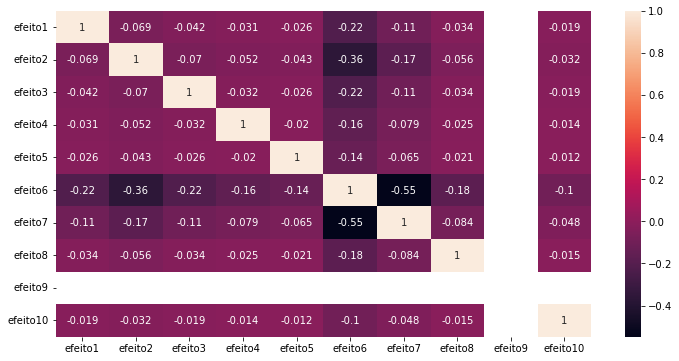

In [112]:
plt.figure(figsize = (12,6))
sns.heatmap(df.loc[:,'efeito1':'efeito10'].corr(), annot = True)

<AxesSubplot:>

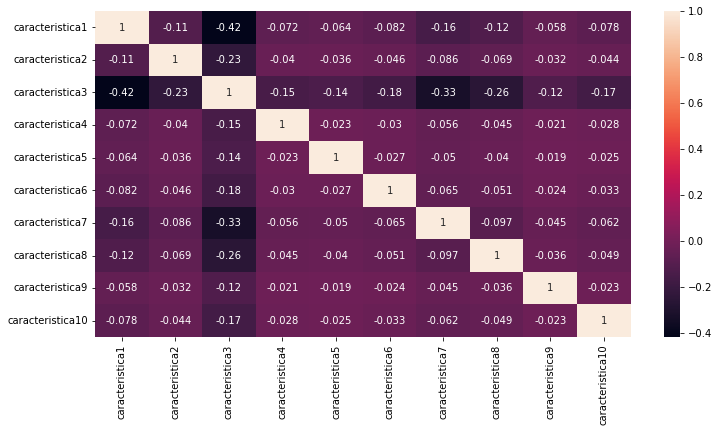

In [113]:
plt.figure(figsize = (12,6))
sns.heatmap(df.loc[:,'caracteristica1':'caracteristica10'].corr(), annot = True)

<AxesSubplot:>

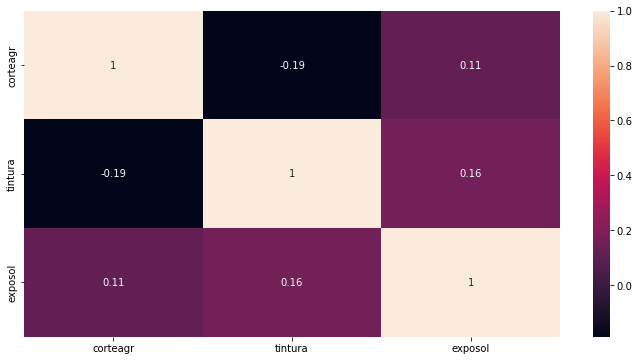

In [114]:
plt.figure(figsize = (12,6))
sns.heatmap(df.loc[:,'corteagr':'exposol'].corr(), annot = True)

In [115]:
df.drop(['efeitos_desejados','caracteristica','procedimentos'], axis = 1, inplace = True)

In [116]:
df.drop(['cidade'], axis = 1, inplace = True)

# Modelagem

* Foram consideradas todas as features presentes na tabela de forms, onde estão as informações comuns aos leads que compraram ou não, excetuando dados de identificação e datas de ocorrência. Também foi excluída a feature de "Locale" por não ter variabilidade, a feature "cidade" por tratar-se de uma feature com muitas categorias e a feature "navegador" por conter muitos valores faltantes e trazer informação muio ligada à coluna "sistema operacional".

* Além disso, foram criadas features para destacar a quantidade de itens contidos nas colunas multilabel como "caracteristica", "procedimento" e "efeito".

In [164]:
X = df.drop(['target', 'navegador'], axis = 1)
y = df.target

In [165]:
# Features ordenáveis e não ordenáveis
ordinal_cols = ['comprimento','faixa_etaria','frequencia_estresse', 'atividade_fisica', 'tempo_procedimento']
ohc_cols     = ['sistema_operacional','tipo_cabelo','tipo_fios','dieta','fragancia', 'utm_source', 'estado'] 

In [166]:
# Ordem de features ordenáveis

comprimento        = ['Raíz exposta','Muito curto','Longo','Extra longo']
faixa_etaria       = ['2 a 10','11 a 17','18 a 24','25 a 34', '35 a 44', '45 a 54', '55 a 64', '65+']
estresse           = ['Nunca','Uma vez por mês', 'Regularmente', 'Quase sempre']
atividade_fisica   = ['N/C','Nunca','Raramente','Frequente','Sempre']
tempo_procedimento = ['Há 1 semana','Há 2 semanas','Há 1 mês','Há mais de 1 mês','Não houve procedimentos']

## Separação treino e teste

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    shuffle = True, 
                                                    random_state = 42, 
                                                    stratify = y)

## Feature Selection (falta)

In [256]:
rfe = RFE(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_features_to_select=40)

## Preprocessamento (manual) dos dados

In [ ]:
X = pd.get_dummies(data = X, columns = ohc_cols)

In [242]:
oe                              = OrdinalEncoder(categories = [comprimento, faixa_etaria, estresse, atividade_fisica, tempo_procedimento])
ohc                             = OneHotEncoder(drop = 'first', sparse = False)

# Treino
X_train.loc[:,ordinal_cols]     = oe.fit_transform(X_train[ordinal_cols])
#X_train                         = pd.get_dummies(data = X_train, columns = ohc_cols)

# Teste
X_test.loc[:,ordinal_cols]     = oe.transform(X_test[ordinal_cols])
#X_test                         = pd.get_dummies(data = X_test, columns = ohc_cols)

## Oversampling

In [243]:
oversampler = SMOTE(sampling_strategy=0.3)

In [ ]:
X_train, y_train = oversampler.fit_resample(X_train, y_train)

## Undersampling

In [ ]:
nr = NearMiss()
ru = RandomUnderSampler(sampling_strategy = 0.4)

In [ ]:
X_train, y_train = ru.fit_sample(X_train,y_train)

In [ ]:
X_test, y_test = nr.fit_sample(X_test,y_test)

In [ ]:
y_train.value_counts(normalize=True)

## Baseline

As técnicas de undersampling e oversampling nao foram eficientes na avaliação dos dados de teste.

Considerando o disparo feito indiscriminadamente a todos os leads, vamos assumir toda a target como valores positivos.

In [168]:
ones = np.ones_like(y_train)

In [169]:
print('Acurácia: ', round(accuracy_score(y_train, ones)*100,2), "%")
print('Precisão: ', round(precision_score(y_train, ones)*100,2), "%")
print('Recall: ', round(recall_score(y_train, ones)*100,2), "%")
print('f1: ', round(f1_score(y_train, ones)*100,2), "%")
print('ROC-AUC: ', round(roc_auc_score(y_train, ones)*100,2), "%")

Acurácia:  10.77 %
Precisão:  10.77 %
Recall:  100.0 %
f1:  19.44 %
ROC-AUC:  50.0 %


Em resumo, apesar de todos os usuários compradores serem alcançados, apenas 11% de todos os disparos se convertem em compra. Em geral, a pontuação ROC AUC de 50% indicia que a performance é puramente aleatória.

In [146]:
#mdl = XGBClassifier(scale_pos_weight = estimate).fit(X_train, y_train)

#y_pred = mdl.predict(X_train)

#roc_auc_score(y_train,y_pred)

#classification_report(y_train, y_pred)

### precision_score(y_train, y_pred)

#plot_confusion_matrix(mdl, X_test, y_test, normalize = 'true')

## Preparação Pipeline

In [147]:
col_transf = ColumnTransformer(transformers = [('ordinal', OrdinalEncoder(categories = [comprimento, faixa_etaria, estresse, atividade_fisica, tempo_procedimento]), ['comprimento','faixa_etaria','frequencia_estresse', 'atividade_fisica', 'tempo_procedimento']),
                                               ('OHC', OneHotEncoder(drop = 'first'), ['sistema_operacional','tipo_cabelo','tipo_fios','dieta','fragancia','estado', 'utm_source']),
                                               ('Scaling', StandardScaler(), ['qtde_lavagem_semana','n_efeitos','n_procedimentos','n_caracteristicas'])]) 

## Model Selection

In [170]:
counter = Counter(y_train)
estimate = counter[0] / counter[1]
estimate

8.287825020969095

In [220]:
skfold = StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)

models = [LogisticRegression(class_weight = {0:.1, 1:.9}),
          #KNeighborsClassifier(),
          #GaussianNB(),
          #SVC(class_weight={0:.2, 1:0.8}),
          DecisionTreeClassifier(class_weight = {0:.1, 1:.9}),
          #ExtraTreeClassifier(class_weight = {0:.1, 1:.9}),
          RandomForestClassifier(class_weight = {0:.1, 1:.9}),
          XGBClassifier(scale_pos_weight = estimate)]
#          Adaboost]

* Dada a natureza do problema, foram selecionados algoritmos de classificação entre modelos lineares e não-lineares para avaliação da melhor performance.
* Em todos os modelos em que foi possível, foi realizado um balanceamento da classe target modificando o peso da penalidade por erro em cada classe. Seguindo o que foi visto na distribuição da classe target, os pesos foram de aprox 10% para a classe 0 e 90% para a classe 1.
* As técnicas de oversampling e undersampling não produziram bons resultados na testagem.

In [221]:
model_scores = []

for model in tqdm(models):
    
    pipe = Pipeline([('encoding', col_transf),
                     ('fs', rfe)
                     ('clf', model)])

    scores = cross_validate(pipe, X_train, y_train, cv = skfold, scoring = ['precision','recall','f1','roc_auc'])
    
    model_scores.append([model, 
                         (round(scores['test_roc_auc'].mean(),2), ' +- ', round(scores['test_roc_auc'].std(),2)), 
                         (round(scores['test_f1'].mean(),2), ' +- ', round(scores['test_f1'].std(),2)) , 
                         (round(scores['test_precision'].mean(),2), ' +- ', round(scores['test_precision'].std(),2)),
                         (round(scores['test_recall'].mean(),2), ' +- ', round(scores['test_recall'].std(),2))
                        ])

model_results = pd.DataFrame(model_scores, columns = ['model','roc_auc','f1', 'precision','recall'])

 75%|█████████████████████████████████           | 3/4 [36:21<16:20, 980.64s/it]

[08:17:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:17:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:17:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|████████████████████████████████████████████| 4/4 [36:50<00:00, 552.63s/it]


Para este case, como a meta principal é a redução de custos com disparos de maneira assertiva, a principal métrica avaliada para qualidade do modelo foi a AUC da curva ROC.

In [222]:
model_results[['model','roc_auc','f1','precision','recall']].sort_values(by=['roc_auc','f1'], ascending = False)

,model,roc_auc,f1,precision,recall
0,"LogisticRegression(class_weight={0: 0.1, 1: 0.9})","(0.67, +- , 0.0)","(0.26, +- , 0.0)","(0.16, +- , 0.0)","(0.68, +- , 0.0)"
3,"XGBClassifier(base_score=None, booster=None, c...","(0.67, +- , 0.0)","(0.26, +- , 0.0)","(0.17, +- , 0.0)","(0.61, +- , 0.0)"
2,"RandomForestClassifier(class_weight={0: 0.1, 1...","(0.62, +- , 0.0)","(0.01, +- , 0.0)","(0.08, +- , 0.01)","(0.01, +- , 0.0)"
1,"DecisionTreeClassifier(class_weight={0: 0.1, 1...","(0.52, +- , 0.0)","(0.14, +- , 0.0)","(0.13, +- , 0.0)","(0.15, +- , 0.0)"


In [257]:
pipe = Pipeline([('encoding', col_transf),
                 ('fs', rfe),
                ('clf',  LogisticRegression(class_weight = 'balanced'))])

In [258]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('encoding',
                 ColumnTransformer(transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['Raíz '
                                                                              'exposta',
                                                                              'Muito '
                                                                              'curto',
                                                                              'Longo',
                                                                              'Extra '
                                                                              'longo'],
                                                                             ['2 '
                                                                              'a '
                                                                              '10',
                                                 

In [259]:
y_pred = pipe.predict(X_train)

In [238]:
precision_score(y_train, y_pred)

0.1547976797819554

In [253]:
roc_auc_score(y_train,y_pred)

0.6131640631522082

## Tunagem de Hiperpârametros

##  Testagem (falta)

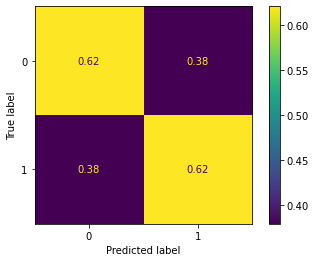

In [254]:
plot_confusion_matrix(pipe, X_test, y_test, normalize = 'true')

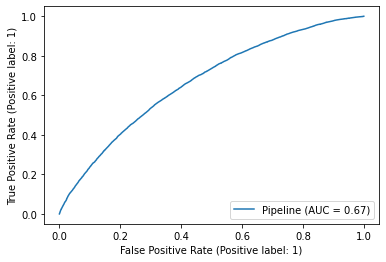

In [255]:
plot_roc_curve(pipe, X_test, y_test)

## Importância de Features

In [199]:
r = permutation_importance(pipe, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

In [203]:
for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i]  >0:
            print(f"{X_train.columns[i]:<8}"
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

utm_source0.016 +/- 0.001
faixa_etaria0.014 +/- 0.001
estado  0.002 +/- 0.001
sistema_operacional0.002 +/- 0.001
n_efeitos0.001 +/- 0.001
n_caracteristicas0.001 +/- 0.001
dieta   0.001 +/- 0.000
tipo_fios0.000 +/- 0.000
qtde_lavagem_semana0.000 +/- 0.000
n_procedimentos0.000 +/- 0.000
frequencia_estresse0.000 +/- 0.000
tempo_procedimento0.000 +/- 0.000
atividade_fisica0.000 +/- 0.000
comprimento0.000 +/- 0.000
fragancia0.000 +/- 0.000


In [204]:
p_imp = pd.Series(r.importances_mean, index = X_test.columns)
p_imp.sort_values(ascending = False, inplace = True)

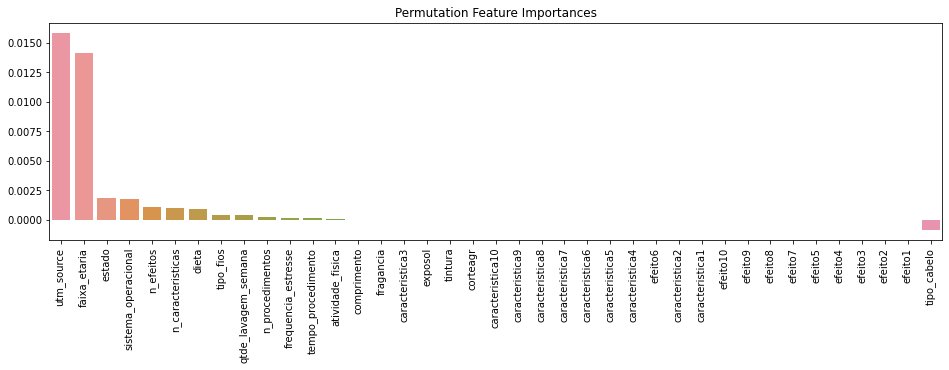

In [206]:
plt.figure(figsize=(16,4))
sns.barplot(x=p_imp.index, y= p_imp.values)
plt.xticks(rotation = 90)
plt.title('Permutation Feature Importances')
plt.show()

As features tem pouco poder preditivo isoladamente, sendo as features de canal de contato e faixa etária as mais representativas com menos de 2% de explicabilidade cada.

## Resultado Econômico do projeto (falta)

Aproximadamente 40% do total em relação ao que antes era enviado.

* A média de preço por disparo no WhatsApp é de cerca de R\\$ 0.12. Considerando que por mês, em média, são preenchidos 72.000 formulários, o aumento na assertividade dos disparos com a redução de 40% nos envios pode gerar uma economia de R\\$ 5.184,00/mês para a empresa, mantendo ainda uma taxa de acerto nos disparos de 62% para leads que são compradores.
